Số lượng Features: 150
Số lượng mẫu Train: 3043
Số lượng mẫu Test : 7135
Tỷ lệ TDE trong Train: 4.86%

===== BẮT ĐẦU TRAINING (5 Folds) =====

--- Fold 1 / 5 ---
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 1	valid's auc: 0.894531
[200]	train's auc: 1	valid's auc: 0.906333
[300]	train's auc: 1	valid's auc: 0.910535
[400]	train's auc: 1	valid's auc: 0.913472
[500]	train's auc: 1	valid's auc: 0.91468
[600]	train's auc: 1	valid's auc: 0.915774
[700]	train's auc: 1	valid's auc: 0.916062
Early stopping, best iteration is:
[643]	train's auc: 1	valid's auc: 0.916695
Fold 1 AUC: 0.9167, PR-AUC: 0.4870

--- Fold 2 / 5 ---
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 1	valid's auc: 0.925446
[200]	train's auc: 1	valid's auc: 0.933218
[300]	train's auc: 1	valid's auc: 0.938054
[400]	train's auc: 1	valid's auc: 0.942084
[500]	train's auc: 1	valid's auc: 0.943293
[600]	train's auc: 1	valid's auc: 0.94525
[700]	train's auc: 1	val

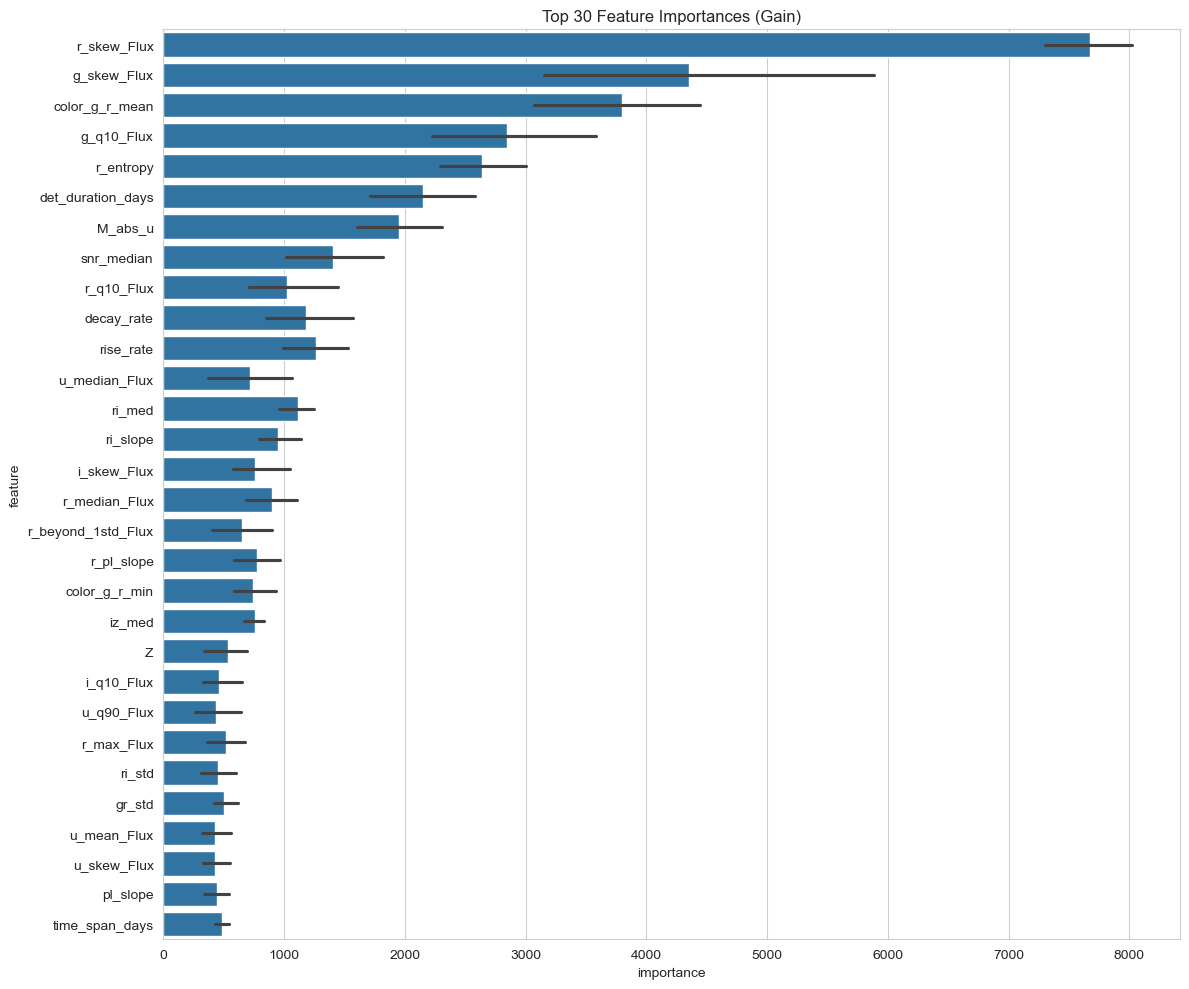


Saved submission to submission_final.csv
Số lượng TDE dự đoán trong tập Test: 375


In [15]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# ====================================================
# 1. CẤU HÌNH & CHUẨN BỊ DỮ LIỆU
# ====================================================
# Load dữ liệu đầu ra từ bước Feature Engineering
# Giả sử bạn đã lưu nó thành file csv hoặc biến đang có sẵn
train_df = pd.read_csv("features_out_data/train_features_all_splits.csv")
test_df = pd.read_csv("features_out_data/test_features_all_splits.csv")

# CÁC CỘT KHÔNG DÙNG ĐỂ TRAIN
IGNORE_COLS = ['object_id', 'target', 'split', 'dataset', 'fold']

# Tự động lấy danh sách features
features = [c for c in train_df.columns if c not in IGNORE_COLS]
target = 'target'

print(f"Số lượng Features: {len(features)}")
print(f"Số lượng mẫu Train: {len(train_df)}")
print(f"Số lượng mẫu Test : {len(test_df)}")
print(f"Tỷ lệ TDE trong Train: {train_df[target].mean()*100:.2f}%")

# ====================================================
# 2. CẤU HÌNH MÔ HÌNH LIGHTGBM
# ====================================================
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',                # Theo dõi AUC trong quá trình train
    'n_estimators': 10000,          # Số lượng cây tối đa (sẽ dừng sớm nhờ early_stopping)
    'learning_rate': 0.02,          # Tốc độ học chậm để hội tụ tốt hơn
    'num_leaves': 31,               # Độ phức tạp của cây
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,        # Subsample hàng
    'feature_fraction': 0.8,        # Subsample cột
    'bagging_freq': 1,
    'lambda_l1': 0.1,               # Regularization L1
    'lambda_l2': 0.1,               # Regularization L2
    'scale_pos_weight': 5.0,        # QUAN TRỌNG: Tăng trọng số cho lớp TDE (Class 1)
    'n_jobs': -1,
    'verbose': -1,
    'random_state': 42
}

# ====================================================
# 3. TRAINING LOOP (STRATIFIED K-FOLD)
# ====================================================
N_FOLDS = 5
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_df))     # Out-of-fold predictions (để đánh giá nội bộ)
test_preds = np.zeros(len(test_df))     # Predictions cho tập test
feature_importance_df = pd.DataFrame()

print(f"\n===== BẮT ĐẦU TRAINING ({N_FOLDS} Folds) =====")

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df[target])):
    print(f"\n--- Fold {fold_ + 1} / {N_FOLDS} ---")
    
    # Chia dữ liệu
    X_trn, y_trn = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx][target]
    X_val, y_val = train_df.iloc[val_idx][features], train_df.iloc[val_idx][target]
    
    # Tạo Dataset cho LightGBM
    dtrain = lgb.Dataset(X_trn, label=y_trn)
    dval = lgb.Dataset(X_val, label=y_val)
    
    # Train
    clf = lgb.train(
        lgb_params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ]
    )
    
    # Predict Validation (OOF)
    val_pred = clf.predict(X_val, num_iteration=clf.best_iteration)
    oof_preds[val_idx] = val_pred
    
    # Predict Test (cộng dồn để lấy trung bình sau này)
    test_preds += clf.predict(test_df[features], num_iteration=clf.best_iteration) / N_FOLDS
    
    # Lưu Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # In điểm số sơ bộ của Fold
    score = roc_auc_score(y_val, val_pred)
    pr_auc = average_precision_score(y_val, val_pred)
    print(f"Fold {fold_ + 1} AUC: {score:.4f}, PR-AUC: {pr_auc:.4f}")

    del X_trn, X_val, y_trn, y_val, clf, dtrain, dval
    gc.collect()

# ====================================================
# 4. ĐÁNH GIÁ TỔNG THỂ & TÌM NGƯỠNG TỐI ƯU
# ====================================================
print("\n===== ĐÁNH GIÁ TỔNG THỂ (OOF) =====")
overall_auc = roc_auc_score(train_df[target], oof_preds)
overall_pr_auc = average_precision_score(train_df[target], oof_preds)
print(f"Overall AUC: {overall_auc:.5f}")
print(f"Overall PR-AUC: {overall_pr_auc:.5f}")

# Tìm Threshold tối ưu hóa F1-Score
best_thresh = 0
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    pred_labels = (oof_preds >= thresh).astype(int)
    f1 = f1_score(train_df[target], pred_labels)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\n✅ Ngưỡng tối ưu (Best Threshold): {best_thresh:.2f}")
print(f"Max F1-Score: {best_f1:.4f}")

# Confusion Matrix tại ngưỡng tối ưu
final_oof_labels = (oof_preds >= best_thresh).astype(int)
cm = confusion_matrix(train_df[target], final_oof_labels)
print("\nConfusion Matrix:")
print(cm)
print(classification_report(train_df[target], final_oof_labels))

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(12, 10))
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('Top 30 Feature Importances (Gain)')
plt.tight_layout()
plt.show()

# ====================================================
# 5. TẠO FILE SUBMISSION
# ====================================================
# Áp dụng ngưỡng tối ưu vào tập Test
# test_df['pred_prob'] = test_preds # Lưu xác suất gốc
test_df['target'] = (test_preds >= best_thresh).astype(int)

# Lưu kết quả
submission = test_df[['object_id', 'target']]
submission.to_csv("submission_final.csv", index=False)
print(f"\nSaved submission to submission_final.csv")
print(f"Số lượng TDE dự đoán trong tập Test: {submission['target'].sum()}")

Số lượng Features: 301
Số lượng mẫu Train: 3043
Số lượng mẫu Test : 7135
Tỷ lệ TDE trong Train: 4.86%

===== BẮT ĐẦU TRAINING (5 Folds) =====

--- Fold 1 / 5 ---
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 1	valid's auc: 0.874036
[200]	train's auc: 1	valid's auc: 0.886586
[300]	train's auc: 1	valid's auc: 0.892228
[400]	train's auc: 1	valid's auc: 0.89787
[500]	train's auc: 1	valid's auc: 0.902303
[600]	train's auc: 1	valid's auc: 0.903569
Early stopping, best iteration is:
[587]	train's auc: 1	valid's auc: 0.9038
Fold 1 AUC: 0.9038, PR-AUC: 0.4424

--- Fold 2 / 5 ---
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 1	valid's auc: 0.928382
[200]	train's auc: 1	valid's auc: 0.934197
[300]	train's auc: 1	valid's auc: 0.93863
[400]	train's auc: 1	valid's auc: 0.941451
[500]	train's auc: 1	valid's auc: 0.943351
[600]	train's auc: 1	valid's auc: 0.943811
[700]	train's auc: 1	valid's auc: 0.945711
[800]	train's auc: 1	valid

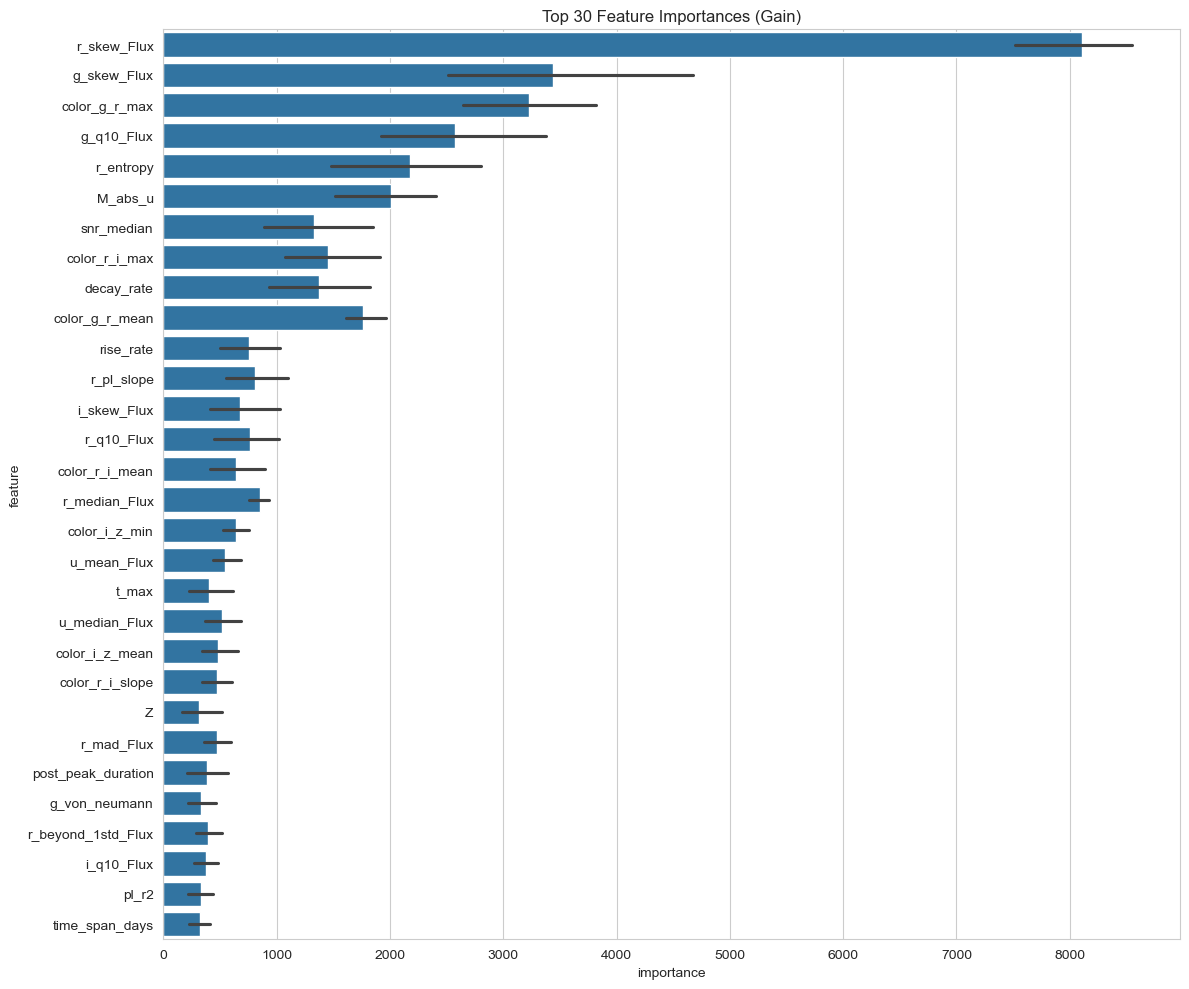


Saved submission to submission_final_v2.csv
Số lượng TDE dự đoán trong tập Test: 397


In [14]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# ====================================================
# 1. CẤU HÌNH & CHUẨN BỊ DỮ LIỆU
# ====================================================
# Load dữ liệu đầu ra từ bước Feature Engineering
# Giả sử bạn đã lưu nó thành file csv hoặc biến đang có sẵn
train_df = pd.read_csv("features_out_data_v2/train_features_all_splits.csv")
test_df = pd.read_csv("features_out_data_v2/test_features_all_splits.csv")

# CÁC CỘT KHÔNG DÙNG ĐỂ TRAIN
IGNORE_COLS = ['object_id', 'target', 'split', 'dataset', 'fold']

# Tự động lấy danh sách features
features = [c for c in train_df.columns if c not in IGNORE_COLS]
target = 'target'

print(f"Số lượng Features: {len(features)}")
print(f"Số lượng mẫu Train: {len(train_df)}")
print(f"Số lượng mẫu Test : {len(test_df)}")
print(f"Tỷ lệ TDE trong Train: {train_df[target].mean()*100:.2f}%")

# ====================================================
# 2. CẤU HÌNH MÔ HÌNH LIGHTGBM
# ====================================================
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',                # Theo dõi AUC trong quá trình train
    'n_estimators': 10000,          # Số lượng cây tối đa (sẽ dừng sớm nhờ early_stopping)
    'learning_rate': 0.02,          # Tốc độ học chậm để hội tụ tốt hơn
    'num_leaves': 31,               # Độ phức tạp của cây
    'max_depth': -1,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,        # Subsample hàng
    'feature_fraction': 0.8,        # Subsample cột
    'bagging_freq': 1,
    'lambda_l1': 0.1,               # Regularization L1
    'lambda_l2': 0.1,               # Regularization L2
    'scale_pos_weight': 5.0,        # QUAN TRỌNG: Tăng trọng số cho lớp TDE (Class 1)
    'n_jobs': -1,
    'verbose': -1,
    'random_state': 42
}

# ====================================================
# 3. TRAINING LOOP (STRATIFIED K-FOLD)
# ====================================================
N_FOLDS = 5
folds = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

oof_preds = np.zeros(len(train_df))     # Out-of-fold predictions (để đánh giá nội bộ)
test_preds = np.zeros(len(test_df))     # Predictions cho tập test
feature_importance_df = pd.DataFrame()

print(f"\n===== BẮT ĐẦU TRAINING ({N_FOLDS} Folds) =====")

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df, train_df[target])):
    print(f"\n--- Fold {fold_ + 1} / {N_FOLDS} ---")
    
    # Chia dữ liệu
    X_trn, y_trn = train_df.iloc[trn_idx][features], train_df.iloc[trn_idx][target]
    X_val, y_val = train_df.iloc[val_idx][features], train_df.iloc[val_idx][target]
    
    # Tạo Dataset cho LightGBM
    dtrain = lgb.Dataset(X_trn, label=y_trn)
    dval = lgb.Dataset(X_val, label=y_val)
    
    # Train
    clf = lgb.train(
        lgb_params,
        dtrain,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=100)
        ]
    )
    
    # Predict Validation (OOF)
    val_pred = clf.predict(X_val, num_iteration=clf.best_iteration)
    oof_preds[val_idx] = val_pred
    
    # Predict Test (cộng dồn để lấy trung bình sau này)
    test_preds += clf.predict(test_df[features], num_iteration=clf.best_iteration) / N_FOLDS
    
    # Lưu Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # In điểm số sơ bộ của Fold
    score = roc_auc_score(y_val, val_pred)
    pr_auc = average_precision_score(y_val, val_pred)
    print(f"Fold {fold_ + 1} AUC: {score:.4f}, PR-AUC: {pr_auc:.4f}")

    del X_trn, X_val, y_trn, y_val, clf, dtrain, dval
    gc.collect()

# ====================================================
# 4. ĐÁNH GIÁ TỔNG THỂ & TÌM NGƯỠNG TỐI ƯU
# ====================================================
print("\n===== ĐÁNH GIÁ TỔNG THỂ (OOF) =====")
overall_auc = roc_auc_score(train_df[target], oof_preds)
overall_pr_auc = average_precision_score(train_df[target], oof_preds)
print(f"Overall AUC: {overall_auc:.5f}")
print(f"Overall PR-AUC: {overall_pr_auc:.5f}")

# Tìm Threshold tối ưu hóa F1-Score
best_thresh = 0
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    pred_labels = (oof_preds >= thresh).astype(int)
    f1 = f1_score(train_df[target], pred_labels)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\n✅ Ngưỡng tối ưu (Best Threshold): {best_thresh:.2f}")
print(f"Max F1-Score: {best_f1:.4f}")

# Confusion Matrix tại ngưỡng tối ưu
final_oof_labels = (oof_preds >= best_thresh).astype(int)
cm = confusion_matrix(train_df[target], final_oof_labels)
print("\nConfusion Matrix:")
print(cm)
print(classification_report(train_df[target], final_oof_labels))

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(12, 10))
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
plt.title('Top 30 Feature Importances (Gain)')
plt.tight_layout()
plt.show()

# ====================================================
# 5. TẠO FILE SUBMISSION
# ====================================================
# Áp dụng ngưỡng tối ưu vào tập Test
# test_df['pred_prob'] = test_preds # Lưu xác suất gốc
test_df['target'] = (test_preds >= best_thresh).astype(int)

# Lưu kết quả
submission = test_df[['object_id', 'target']]
submission.to_csv("submission_final.csv_v2", index=False)
print(f"\nSaved submission to submission_final_v2.csv")
print(f"Số lượng TDE dự đoán trong tập Test: {submission['target'].sum()}")